In [79]:
#Importing required libraries
import numpy as np
import pandas as pd
np.random.seed(3116)

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### Reading the dataset

In [80]:
data = pd.read_csv("nursery.data",sep = ',',header=0,index_col=False)
data

,parents,has_nurs,form,children,housing,finance,social,health,Nursery
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [81]:
data_headers = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'Nursery']
print(" The attributes of nursery dataset is : ",data_headers)

 The attributes of nursery dataset is :  ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'Nursery']


In [82]:
target_column = 8

In [83]:
# GENERATING DATASET SPLITS
# The following function take a dataframe object as input and returns 3 dfs having train/test/validation instances

def train_test_val_split(df, test_ratio, val_ratio):
    n_test = int(test_ratio*df.shape[0]) #Training/validation set size within current class label
    n_val = int(val_ratio*df.shape[0])
    n_train = df.shape[0] - n_test - n_val
    permute = np.random.permutation(df.index)
    train = df.iloc[permute[:n_train]].to_numpy()
    val = df.iloc[permute[n_train : n_train+n_val]].to_numpy()
    test = df.iloc[permute[n_train+n_val:]].to_numpy()
    dataset = [train, val, test] #List of all required dataset splits
    return dataset

In [84]:
#Applying the above function on Iris master dataframe created above
test_ratio, val_ratio = 0.15, 0.15
data_splits = train_test_val_split(data, test_ratio, val_ratio)
train_data, val_data, test_data = data_splits
print('\nShape of train set is: ',train_data.shape)
print('\nShape of validation set is: ',val_data.shape)
print('\nShapes of test set are: ',test_data.shape)



Shape of train set is:  (9072, 9)

Shape of validation set is:  (1944, 9)

Shapes of test set are:  (1944, 9)


##### Class to represent the condition inside each node in a decision tree

In [85]:
class Tree:
    #Initializer/Constructor Function
    def __init__(self, column_name, column, value):
        #Feature Name
        self.column_name = column_name
        #Feature Column Index
        self.column = column
        #Feature Value
        self.feature_value = value
        #Is the feature value numeric or Categorical
        self.feature_numeric = isinstance(self.feature_value, int) or isinstance(self.feature_value, float)
    
    #Function to evaluate an instance on the current condition
    def evaluate(self, row):
        #Extracting the value at column of given instance
        value = row[self.column]
        #If the value is numerical than check for less than equal to condition
        if isinstance(value, int) or isinstance(value, float):
            return value <= self.feature_value
        #If the value is categorical than check for equals condition
        return value == self.feature_value
    
    #Function to split the dataset into left dataset and right dataset based on the current condition
    def apply_split(self, dataset):
        #List to contain the left and right dataset
        left_partition, right_partition = [], []
        #Iterating through all instances and evaluating the condition
        for row in dataset:
            #If true, then appending that instance into left dataset
            if self.evaluate(row):
                left_partition.append(row)
            #If False, then appending that instance into right dataset
            else:
                right_partition.append(row)
        #Returning the Left and Right Datasets
        return np.array(left_partition), np.array(right_partition)
    
    #Function to print the condition in a formatted way
    def to_string(self):
        #If feature is numeric than print <= else ==
        check_condition = '<=' if self.feature_numeric else '=='
        #Returning the formatted condition String
        return 'check for {} {} {}'.format(self.column_name, check_condition, self.feature_value)

Function to return the dominant class from the dataset

In [86]:
def dominant_class(dataset, target_column):
    #Extracting only the class column from the dataset
    target_values = dataset[:,target_column]
    # print(target_values)
    #Extracting the unique classes and their counts
    unique_values, counts = np.unique(target_values, return_counts=True)
    dominant_class = unique_values[np.argmax(counts)]
    #Returning the unique classes and their counts
    return (target_values == dominant_class).sum(), dominant_class

**Misclassification rate** is a metric that tells us the percentage of observations that were incorrectly predicted by some classification model.

It is calculated as: Misclassification Rate = # incorrect predictions / # total predictions<br>
The value for misclassification rate can range from 0 to 1 where:<br>
 - 0 represents a model that had zero incorrect predictions.
 - 1 represents a model that had completely incorrect predictions.<br>
The lower the value for the misclassification rate, the better a classification model is able to predict the outcomes of the response variable.

In [87]:
def MCR(dataset, target_column, condition):
    #Splitting the dataset into left and right dataset based on the condition of the node
    left_data, right_data = condition.apply_split(dataset)
    #If any of the left/right dataset is empty then return the highest MCR which is 1
    if len(left_data) == 0 or len(right_data) == 0:
        return 1
    #Extracting the dominant class and its count from the left dataset
    left_dominant_count, left_dominant_class = dominant_class(left_data, target_column)
    #Extracting the dominant class and its count from the Right dataset
    right_dominant_count, right_dominant_class = dominant_class(right_data, target_column)
    #Returning the MCR = ((|LD| - |LD_dominant_class_count|) + (|RD| - |RD_dominant_class_count|)) / |D|
    return ((len(left_data) - left_dominant_count) + (len(right_data) - right_dominant_count)) / len(dataset)

**Cross-entropy** is commonly used as a loss function for classification problems. <br>
Cross-entropy measures the relative entropy between two probability distributions over the same set of events.<br>
The function below retuens the cross entropy value.

In [88]:
def cross_entropy(dataset, target_column):
    #Initializing the entropy to 0
    entropy = 0
    #Extracting the unique classes and its count from the class column
    unique_values, count= np.unique(dataset[:,target_column], return_counts=True)
    #Iterating over all unique classes
    for index, unique_val in enumerate(unique_values):
        #Calculating probability = |unique_class| / |D|
        probability = count[index] / len(dataset)
        entropy += (probability * np.log2(probability))  
    #Returning the negative of entropy
    return -1 * entropy

**Information Gain** is the measure of how much information a feature provides about a class. It helps to determine the order of attributes in the nodes of a decision tree.<br>
The main node is referred to as the parent node, whereas sub-nodes are known as child nodes. Information gain is used to determine how good the splitting of nodes in a decision tree.

In [89]:
def information_gain(dataset, left_dataset, right_dataset, target_column):
    #Calculating the Cross Entropy of the whole Dataset
    weighted_entropy = cross_entropy(dataset, target_column)
    left_dataset=np.array(left_dataset)
    #Calculating the Weighted entropy of the Left Dataset
    left_dataset_entropy = (len(left_dataset)/len(dataset)) * cross_entropy(left_dataset, target_column)
    right_dataset=np.array(right_dataset)
    #Calculating the Weighted entropy of the Right Dataset
    right_dataset_entropy = (len(right_dataset)/len(dataset)) * cross_entropy(right_dataset, target_column)
    #Returning the Information Gain = H(D) - (W_H(LD) + W_H(RD))
    return weighted_entropy - (left_dataset_entropy + right_dataset_entropy)

The function below retuns the average value between each datapoint for all the numerical columns.

In [90]:
def average_numerical_cols(values):
    #Initializing the list
    V = []
    #Iterating through each values in pair
    for i in range(len(values) - 1):
        #Calculating the average between two consecutive numbers
        V.append((values[i] + values[i+1])/2)    
    #Returning the calculated List V
    return V

The function below returns the best MCR value along with the best splitting condition.

In [91]:
def best_fit_mcr(dataset, headers, target_column):
    #Initializing the best MCR to 1 and best Condition to None
    best_mcr = 1
    best_condition = None
    #Iterating through all feature columns
    for i in range(len(dataset[0])):
        #We do not consider the target column
        if i == target_column:
            continue
        #Extracting the unique values from the selected column
        unique_values = np.unique(dataset[:,i])
        #If the column values are numeric than calculating the list containing the average values between two consecutive numbers
        if isinstance(unique_values[0], int) or isinstance(unique_values[0], float):
            unique_values = average_numerical_cols(unique_values)
        #Iterating through all unique values
        for unique_val in unique_values:
            #Creating a condition with selected feature and unique value
            condition = Tree(headers[i], i, unique_val)
            #Calculating the MCR value for that condition
            mcr = MCR(dataset, target_column, condition)
            #If we find a better MCR then swapping it with the previous best
            if mcr <= best_mcr:
                best_mcr = mcr
                best_condition = condition
    #Returning the Best MCR and Best Condition
    return best_mcr, best_condition

The function below returns the best Information Gain value along with the best splitting condition.

In [92]:
def best_fit_gain(dataset, headers, target_column):
    #Initializing the best Information Gain to 0 and best Condition to None
    best_gain = 0
    best_condition = None
    #Iterating through all feature columns
    for i in range(len(dataset[0])):
        #We do not consider the target column
        if i == target_column:
            continue
        #Extracting the unique values from the selected column
        unique_values = np.unique(dataset[:,i])
        #If the column values are numeric than calculating the list containing the average values between two consecutive numbers
        if isinstance(unique_values[0], int) or isinstance(unique_values[0], float):
            unique_values = average_numerical_cols(unique_values)
        #Iterating through all unique values
        for unique_val in unique_values:
            #Creating a condition with selected feature and unique value
            condition = Tree(headers[i], i, unique_val)
            #Calculating the Information Gain value for that condition
            left_data , right_data = condition.apply_split(dataset)
            gain = information_gain(dataset, left_data, right_data, target_column)
            #If we find a better Information Gain then swapping it with the previous best
            if gain >= best_gain:
                best_gain = gain
                best_condition = condition
    #Returning the Best Information Gain and Best Condition          
    return best_gain, best_condition

##### Class to Represent a Node in the Tree

In [93]:
class Node:
    #Initializer/Constructor Function
    def __init__(self, condition, left_node, right_node, is_leaf, leaf_class):
        #Condition of the Node
        self.condition = condition
        #Left Child Node
        self.left_node = left_node
        #Right Child Node
        self.right_node = right_node
        #If the Node is a Leaf Node
        self.is_leaf = is_leaf
        #If it is Leaf Node then its output value
        self.leaf_class = leaf_class

#### Fucntion to learn the decision tree from the dataset

In [94]:
def learn_decision_tree(dataset, headers, target_column, evaluation_metric = 'mcr', max_depth = 2):
    #Calculating the Best Condition based on Either MCR or Information Gain
    if evaluation_metric == 'mcr':
        eval_val , condition = best_fit_mcr(dataset, headers, target_column) 
    else:
        eval_val , condition = best_fit_gain(dataset, headers, target_column)
    #At each decision step (or split) presenting the probability of each class using Bar Plot
    unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
    plt.bar(unique_values, counts)
    plt.title('Probabilities of each class at Level: {}'.format(max_depth))
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()
    if max_depth == 0:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        #Returning the Node
        return Node(condition, None, None, True, dominant_class)
    
    #If MCR is 1 or Information Gain is 0 or the condition is Null, then it is Leaf node
    if (evaluation_metric == 'mcr' and eval_val == 1) or (evaluation_metric == 'gain') or condition == None:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        #Returning the Leaf Node
        return Node(condition, None, None, True, dominant_class)

    #Split the Data into Left and Right Dataset based on Best Condition
    left_data, right_data = condition.apply_split(dataset)
    # left_data=np.array(left_data)
    # right_data = np.array(right_data)
    #Creating a Left Child Node using Recursive call
    left_node = learn_decision_tree(left_data, headers, target_column, evaluation_metric, max_depth - 1)
    #Creating a Right Child Node using Recursive call
    right_node = learn_decision_tree(right_data, headers, target_column, evaluation_metric, max_depth - 1)
    #Returning the Node which is not Leaf and contains Left and Right Nodes
    return Node(condition, left_node, right_node, False, '')

In [95]:
def learn_decision_tree_gain(dataset, headers, target_column, evaluation_metric = 'gain', max_depth = 2):
    #Calculating the Best Condition based on Either MCR or Information Gain

    eval_val , condition = best_fit_gain(dataset, headers, target_column)
    #At each decision step (or split) presenting the probability of each class using Bar Plot
    unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
    plt.bar(unique_values, counts)
    plt.title('Probabilities of each class at Level: {}'.format(max_depth))
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()
    if max_depth == 0:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        #Returning the Node
        return Node(condition, None, None, True, dominant_class)
    
    #If MCR is 1 or Information Gain is 0 or the condition is Null, then it is Leaf node
    if (evaluation_metric == 'gain') or condition == None:
        #Extracting the Dominant Class
        unique_values, counts = np.unique(dataset[:,target_column], return_counts=True)
        dominant_class = unique_values[np.argmax(counts)]
        #Returning the Leaf Node
        return Node(condition, None, None, True, dominant_class)
    #Split the Data into Left and Right Dataset based on Best Condition
    left_data, right_data = condition.apply_split(dataset)
    #Creating a Left Child Node using Recursive call
    left_node = learn_decision_tree_gain(left_data, headers, target_column, evaluation_metric, max_depth - 1)
    #Creating a Right Child Node using Recursive call
    right_node = learn_decision_tree_gain(right_data, headers, target_column, evaluation_metric, max_depth - 1)
    #Returning the Node which is not Leaf and contains Left and Right Nodes
    return Node(condition, left_node, right_node, False, '')

#### Function to Print The Tree

In [96]:
def print_tree(root, spaces = ''):
    #The the node is Leaf node, than printing its predicted class with spaces indicating depth
    if root.is_leaf:
        print(spaces + 'Leaf Node: ' + str(root.leaf_class))
        return
    #Printing the Node Condition
    print(spaces + root.condition.to_string())
    #Printing the Left Node if the Condition is True
    print(spaces + 'True: ')
    print_tree(root.left_node, spaces + '  ')
    #Printing the Right Node if the Condition is False
    print(spaces + 'False: ')
    print_tree(root.right_node, spaces + '  ')

##### Function to Predict the Class of the Selected Row Instance using Decision Tree

In [97]:
def predict_class(tree , row):
    #If the Node is leaf, then returning the leaf class
    if tree.is_leaf:
        return tree.leaf_class
    #If the Node condition is True, then predicting the class with the left Node
    if tree.condition.evaluate(row):
        return predict_class(tree.left_node, row)
    #If the Node condition is False, then predicting the class with the Right Node
    else:
        return predict_class(tree.right_node, row)

##### Function to Predict the Classes of the entire Dataset using Decision Tree

In [98]:
def predict_classes(tree, dataset):
    #Initializing the empty list for classes
    predicted_classes = []
    #Iterating through all the rows in the dataset
    for row in dataset:
        #Appending the predicted class to the list
        predict_classes.append(predict_class(tree, row))
    #Returning the Predicted Class list
    return predicted_classes

##### Function to Calculate the Accuracy of the Decision Tree

In [99]:
def accuracy(tree, dataset, target_column):
    #Initializing the Correct prediction to 0
    correct = 0
    #Iterating through all instances
    for row in dataset:
        #Checking if the actual class is equal to the predicted class
        if row[target_column] == predict_class(tree, row):
            correct += 1     
    #Returning the Accuracy = correct Result / Total Rows
    return correct/len(dataset)

In [100]:
max_depth_list = [1,2,3]

#### Part A: Experimenting with Quality-criterion: Cross Entropy

##### Printing the Resultant Tree and Displaying the Accuarcy and Cross Entropy Loss

Learning Decision Tree with Misclassification Rate and Max Depth: 1



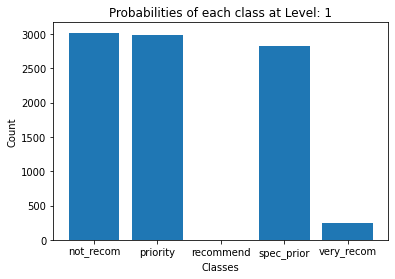

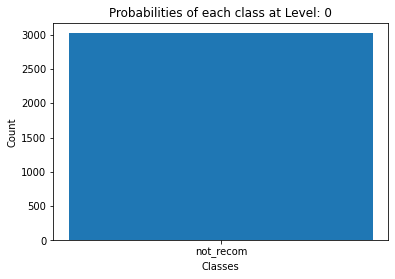

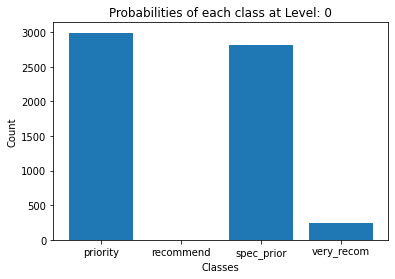

Printing the Tree using a breath first tree traversal:

check for health == not_recom
True: 
  Leaf Node: not_recom
False: 
  Leaf Node: priority

Accuracy: 0.6712962962962963

Log Loss/ Cross Entropy Loss: 0.3985446652635906

Learning Decision Tree with Misclassification Rate and Max Depth: 2



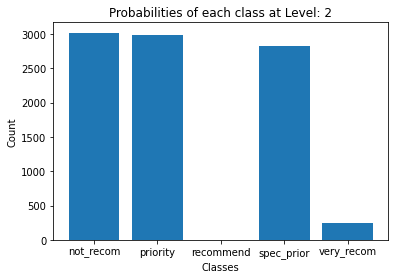

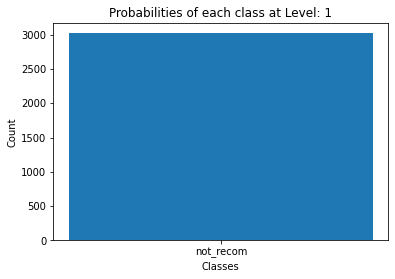

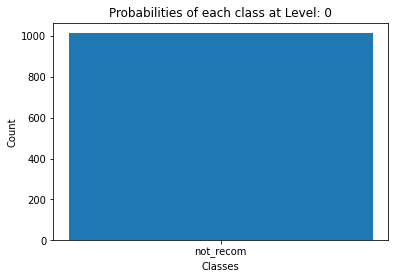

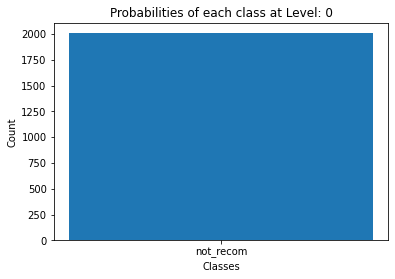

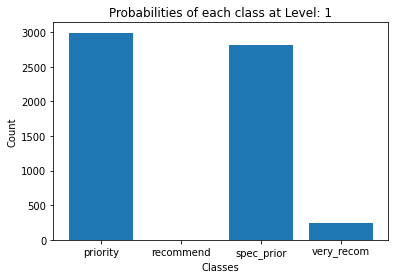

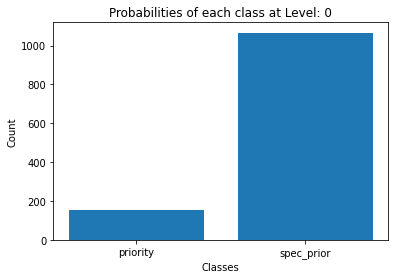

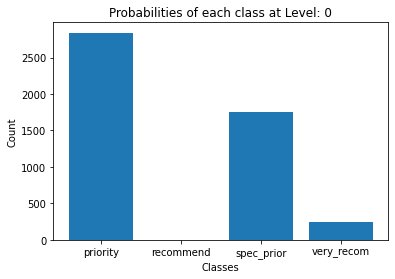

Printing the Tree using a breath first tree traversal:

check for health == not_recom
True: 
  check for social == slightly_prob
  True: 
    Leaf Node: not_recom
  False: 
    Leaf Node: not_recom
False: 
  check for has_nurs == very_crit
  True: 
    Leaf Node: spec_prior
  False: 
    Leaf Node: priority

Accuracy: 0.7788065843621399

Log Loss/ Cross Entropy Loss: 0.24999255102299034

Learning Decision Tree with Misclassification Rate and Max Depth: 3



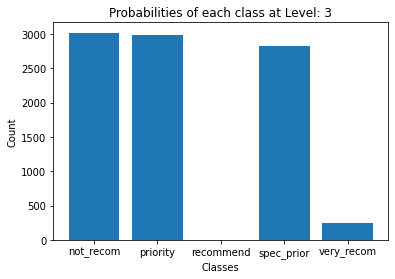

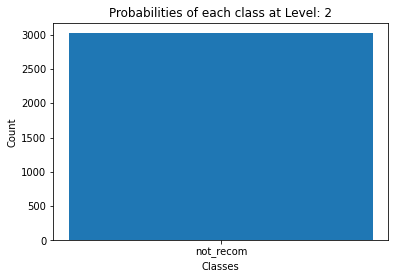

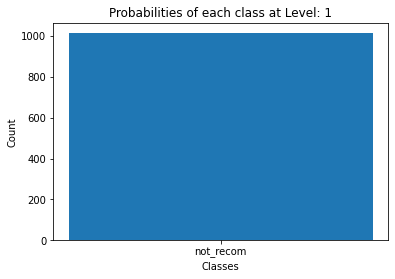

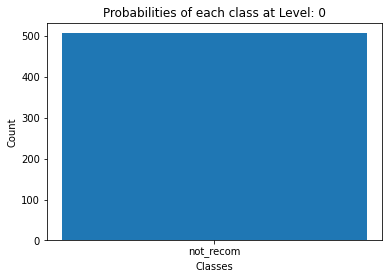

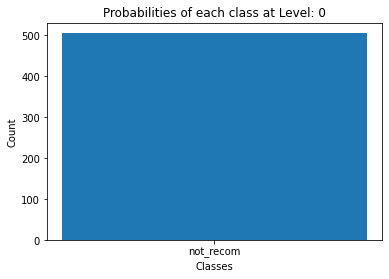

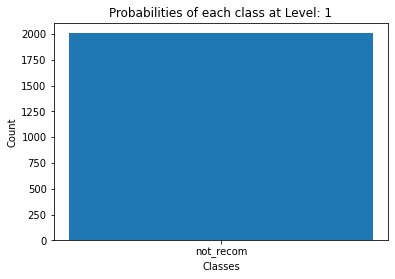

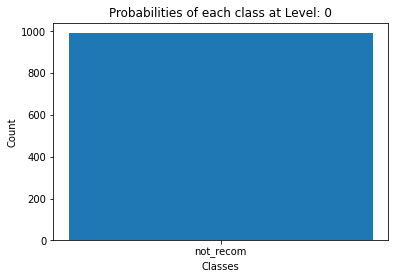

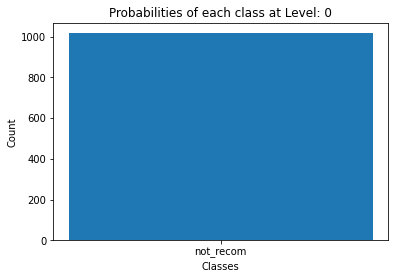

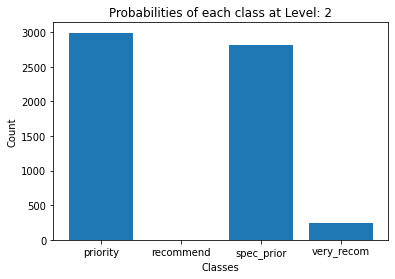

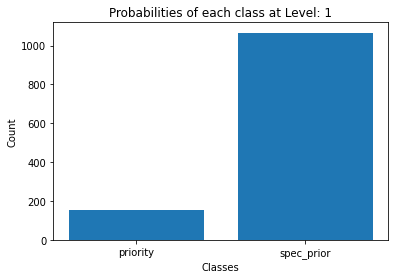

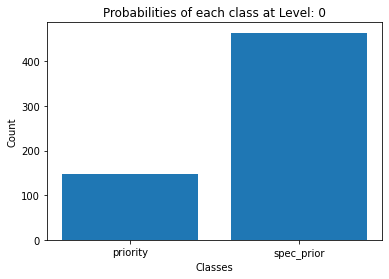

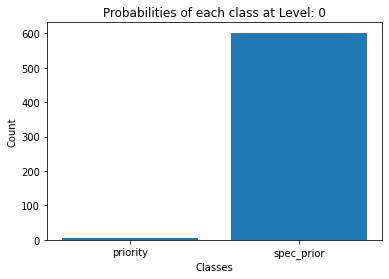

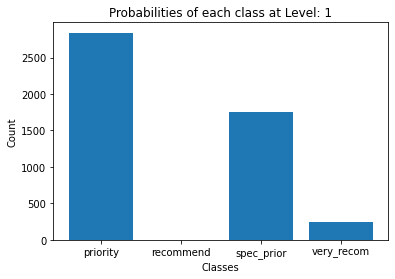

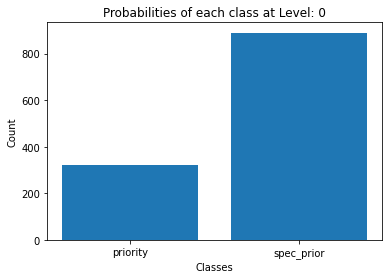

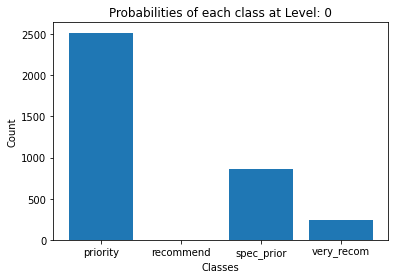

Printing the Tree using a breath first tree traversal:

check for health == not_recom
True: 
  check for social == slightly_prob
  True: 
    check for finance == inconv
    True: 
      Leaf Node: not_recom
    False: 
      Leaf Node: not_recom
  False: 
    check for social == problematic
    True: 
      Leaf Node: not_recom
    False: 
      Leaf Node: not_recom
False: 
  check for has_nurs == very_crit
  True: 
    check for health == recommended
    True: 
      Leaf Node: spec_prior
    False: 
      Leaf Node: spec_prior
  False: 
    check for has_nurs == critical
    True: 
      Leaf Node: spec_prior
    False: 
      Leaf Node: priority

Accuracy: 0.8307613168724279

Log Loss/ Cross Entropy Loss: 0.18541274936362753



In [101]:
for max_depth in max_depth_list:
    # print('--------------------------------------------------------------\n')
    print('Learning Decision Tree with Misclassification Rate and Max Depth: {}\n'.format(max_depth))
    root = learn_decision_tree(train_data, data_headers, target_column, 'mcr' , max_depth)
    print('Printing the Tree using a breath first tree traversal:\n')
    print_tree(root)
    print('\nAccuracy: {}\n'.format(accuracy(root, val_data, target_column)))
    print('Log Loss/ Cross Entropy Loss: {}\n'.format(-1 * np.log(accuracy(root, val_data, target_column))))

#### Part B: Experimenting with other Quality-criterion: Information Gain

In [102]:
max_depth_list = [1,2,3,4,5]

Learning Decision Tree with Information gain and Max Depth: 1



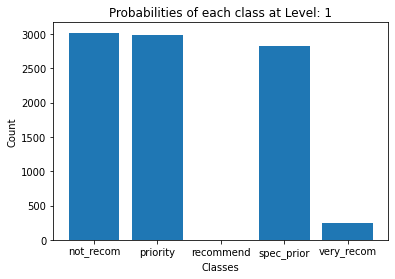

Printing the Tree using a breath first tree traversal:

Leaf Node: not_recom

Accuracy: 0.345679012345679

Cross Entropy Loss: 1.0622446444972349

Learning Decision Tree with Information gain and Max Depth: 2



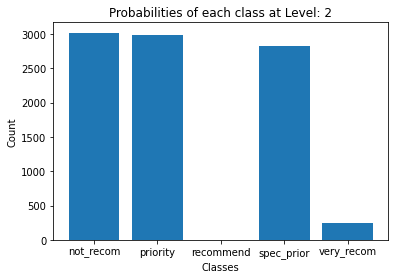

Printing the Tree using a breath first tree traversal:

Leaf Node: not_recom

Accuracy: 0.345679012345679

Cross Entropy Loss: 1.0622446444972349

Learning Decision Tree with Information gain and Max Depth: 3



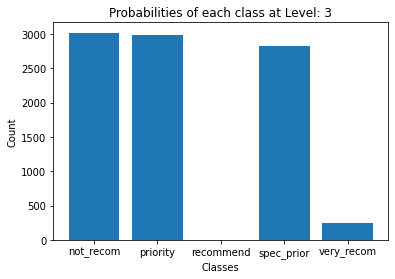

Printing the Tree using a breath first tree traversal:

Leaf Node: not_recom

Accuracy: 0.345679012345679

Cross Entropy Loss: 1.0622446444972349

Learning Decision Tree with Information gain and Max Depth: 4



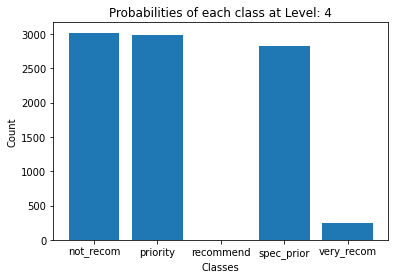

Printing the Tree using a breath first tree traversal:

Leaf Node: not_recom

Accuracy: 0.345679012345679

Cross Entropy Loss: 1.0622446444972349

Learning Decision Tree with Information gain and Max Depth: 5



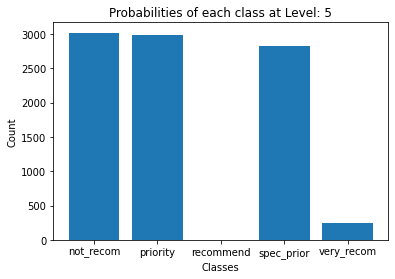

Printing the Tree using a breath first tree traversal:

Leaf Node: not_recom

Accuracy: 0.345679012345679

Cross Entropy Loss: 1.0622446444972349



In [103]:
for max_depth in max_depth_list:
    # print('--------------------------------------------------------------\n')
    print('Learning Decision Tree with Information gain and Max Depth: {}\n'.format(max_depth))
    root = learn_decision_tree_gain(train_data, data_headers, target_column, 'gain' , max_depth)
    print('Printing the Tree using a breath first tree traversal:\n')
    print_tree(root)
    print('\nAccuracy: {}\n'.format(accuracy(root, val_data, target_column)))
    print('Cross Entropy Loss: {}\n'.format(-1 * np.log(accuracy(root, val_data, target_column))))